In [129]:
#Initial configuration, probably overkill in imports.
import sys, os, re
import numpy as np
import pandas as pd
import allel
import zarr
import dask
import numcodecs
import warnings
from pathlib import Path


%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set()
sns.set_theme()
sns.set_style("white")
sns.set_context("notebook")

Various parts of the following code is taken from Kaspers scikit-allel

In [2]:
#Dask setup
from multiprocessing.pool import ThreadPool
import dask
dask.config.set(pool=ThreadPool(int(os.environ['SLURM_CPUS_PER_TASK'])))

In [3]:
#Sample information and chromosome lengths
chromosome_lengths = dict()
for line in open('../data/macFas5.chrom.sizes.txt'): # NB MACAQUE REF GENOME...
    chrom, length = line.split()
    chromosome_lengths[chrom] = int(length)
    
chromosomes = [f'chr{x}' for x in range(1, 21)] + ['chrX']
meta_data = pd.read_excel('../data/Papio-Genomes_JR_120720_MR-CR-KM_geoloc.xlsx')
with pd.option_context("display.max_rows", 1000):
    display(meta_data)
baboon_samples = [x for x in meta_data.PGDP_ID if x.startswith('PD')] #  NB: to not get the SciAdvPaper samples



,Unnamed: 0,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude
0,0,PD_0067,1043,Roos,Theropithecus,gelada,captive,M,"SDSU Captive Wildlife Research Facility, Brook...",-96.793280,44.334031
1,1,PD_0199,09SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626
2,2,PD_0200,11SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626
3,3,PD_0201,19SNM1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626
4,4,PD_0202,20SNF1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626
5,5,PD_0203,21SNF1151115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626
6,6,PD_0204,03ANM1080815,Knauf/Chuma/Roos,Papio,anubis,"Arusha, Tanzania",M,"Arusha, Northern Zone, Tanzania",36.708585,-3.427534
7,7,PD_0205,05ANF1030116,Knauf/Chuma/Roos,Papio,anubis,"Arusha, Tanzania",F,"Arusha, Northern Zone, Tanzania",36.708585,-3.427534
8,8,PD_0206,09ANF1040116,Knauf/Chuma/Roos,Papio,anubis,"Arusha, Tanzania",F,"Arusha, Northern Zone, Tanzania",36.708585,-3.427534
9,9,PD_0207,12ANM1050116,Knauf/Chuma/Roos,Papio,anubis,"Arusha, Tanzania",M,"Arusha, Northern Zone, Tanzania",36.708585,-3.427534


In [4]:
#Opening the zarr data
callset = zarr.open_group('/faststorage/project/primatediversity/people/kmt/baboon_flagship/steps/callset.zarr', mode='r')
callset.tree(expand=False)

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='chr1', nodes=(Node(disabled=True, n…

In [5]:
#Callability data
called_interv = zarr.open_group('/faststorage/project/primatediversity/people/kmt/baboon_flagship/steps/called_interv.zarr', mode='r')
called_interv.tree(expand=False)

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='PD_0199', nodes=(Node(disabled=True…

Checking a bit up on the samples present, and the metadata associated with it

In [6]:
#Checking that sample order is the same for all chrom
np.all([np.all(callset['chr1/samples'][:] == callset[f'{chrom}/samples'][:]) for chrom in chromosomes])

True

In [7]:
#Meta data for the sample present in the zarr data structure - Kasper has removed some of the samples.
samples_list = list(callset['chr1/samples'][:])
meta_data_samples = meta_data.loc[meta_data.PGDP_ID.isin(samples_list)].copy()
samples_callset_index = [samples_list.index(s) for s in meta_data_samples.PGDP_ID]
meta_data_samples['callset_index'] = samples_callset_index
print(meta_data_samples.head())
len(meta_data_samples) #So in the zarr dataset, 160 individuals are present.

   Unnamed: 0  PGDP_ID   Provider_ID          Provider  Genus Species  \
1           1  PD_0199  09SNF1101115  Knauf/Chuma/Roos  Papio  anubis   
2           2  PD_0200  11SNF1101115  Knauf/Chuma/Roos  Papio  anubis   
3           3  PD_0201  19SNM1131115  Knauf/Chuma/Roos  Papio  anubis   
4           4  PD_0202  20SNF1131115  Knauf/Chuma/Roos  Papio  anubis   
5           5  PD_0203  21SNF1151115  Knauf/Chuma/Roos  Papio  anubis   

                Origin Sex                               address  longitude  \
1  Serengeti, Tanzania   F  Serengeti, Mara, Lake Zone, Tanzania  34.742544   
2  Serengeti, Tanzania   F  Serengeti, Mara, Lake Zone, Tanzania  34.742544   
3  Serengeti, Tanzania   M  Serengeti, Mara, Lake Zone, Tanzania  34.742544   
4  Serengeti, Tanzania   F  Serengeti, Mara, Lake Zone, Tanzania  34.742544   
5  Serengeti, Tanzania   F  Serengeti, Mara, Lake Zone, Tanzania  34.742544   

   latitude  callset_index  
1 -1.996626              0  
2 -1.996626              1  

160

In [8]:
#Overview of species, with each species having an array containing all the number in the updated metadata list
species_index = dict()
for species in meta_data_samples.Species.unique():
    species_index[species] = meta_data_samples[meta_data_samples.Species == species].callset_index.values

In [9]:
#Choosing which variants to pick
allelic = callset['chr20/variants/numalt'][:] > 0
print(len(callset['chr20/variants/numalt'][:]))
print(sum(callset['chr20/variants/numalt'][:])) #Some variants are multi-allelic in the dataset
print(sum(callset['chr20/variants/numalt'][:] == 0)) #No variable sites have no alternative allele
print(sum(callset['chr20/variants/numalt'][:] == 2)) #Almost all sites with more than one alt has two

3328367
3372201
0
43061


In [1]:
#Picking out anubis based on metadata
male = meta_data_samples[meta_data_samples.Sex == "M"].callset_index.values
len(male)

NameError: name 'meta_data_samples' is not defined

In [11]:
#Creating the genotype array
gt_zarr = callset["chr20/calldata/GT"]
gt = allel.GenotypeDaskArray(gt_zarr)
gt_allelic = gt.compress(allelic, axis=0)
gt_allelic

<GenotypeDaskArray shape=(3328367, 160, 2) dtype=int8>

In [12]:
#Picking out the anubis
gt_anubis = gt_allelic.take(anubis, axis=1)
gt_anubis

<GenotypeDaskArray shape=(3328367, 51, 2) dtype=int8>

In [13]:
#Doing both parts at the same time using subset and dask
gt_anubis = gt.subset(allelic, anubis).compute()
gt_anubis

<GenotypeArray shape=(3328367, 51, 2) dtype=int8>
./. ./. 0/0 ./. ./. ... ./. ./. ./. ./. ./.
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 ./. 0/0 0/0
0/0 0/0 0/0 1/1 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
./. ./. 0/0 0/0 ./. ... ./. ./. ./. ./. 1/1
./. ./. ./. 0/0 ./. ... ./. ./. ./. ./. 0/0
0/0 ./. ./. ./. 0/0 ... ./. ./. ./. ./. 0/0

In [14]:
#Keeping all alleles, only picking individuals. Is equivalent to earlier, as all alleles were taken.
gt_anubis = gt.take(anubis, axis=1)
gt_anubis

<GenotypeDaskArray shape=(3328367, 51, 2) dtype=int8>

In [15]:
gt_anubis.count_het()

7063153

In [16]:
#Calculating number of heterozygous sites for a single individuals chromosome
(gt.take([1], axis=1)).count_het()

148744

In [17]:
meta_data_samples

,Unnamed: 0,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,callset_index
1,1,PD_0199,09SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,0
2,2,PD_0200,11SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,1
3,3,PD_0201,19SNM1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,2
4,4,PD_0202,20SNF1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,3
5,5,PD_0203,21SNF1151115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,4
...,...,...,...,...,...,...,...,...,...,...,...,...
212,212,PD_0789,34417_BZ11064,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,155
213,213,PD_0790,34418_BZ11065,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,156
214,214,PD_0791,34419_BZ11066,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,157
215,215,PD_0792,34420_BZ11067,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,158


In [18]:
#Test subset of individuals
test_subset = meta_data_samples.take([0, 10, 70, 159])
test_subset

,Unnamed: 0,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,callset_index
1,1,PD_0199,09SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,0
11,11,PD_0209,05NCF1150516,Knauf/Chuma/Roos,Papio,anubis,"Ngorongoro, Tanzania",F,"Ngorongoro, Arusha, Northern Zone, Tanzania",35.585946,-2.676953,10
127,127,PD_0704,39885_97090,Jolly/Phillips-Conroy,Papio,hamadryas,"Filoha, Ethiopia",M,Awash National Park in Ethiopia,40.000005,9.083582,70
216,216,PD_0793,34422_BZ11070,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",M,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,159


In [19]:
#Setting up a function to count heterozygous sites for each individual
## The dataset should only have females in it, as males cannot be heterozygous in the X chromosome
#Or at least remove the X dataset from males.

het_df = pd.DataFrame(columns = chromosomes)
for chrom in chromosomes:
    gt_zarr = callset["{}/calldata/GT".format(chrom)]
    gt = allel.GenotypeDaskArray(gt_zarr)
    for i, row in meta_data_samples.iterrows():
        het_count = (gt.take([row.callset_index], axis=1)).count_het()
        het_df.at[row.PGDP_ID, chrom] = het_count
    print("Finished {}".format(chrom))


Finished chr1


KeyboardInterrupt: 

In [ ]:
#het_df.to_csv("../steps/het_counts.txt", sep = " ")
het_df

In [ ]:
#Calculating length of intervals
call_df = pd.DataFrame(columns = chromosomes)
for chrom in chromosomes:
    for i, row in meta_data_samples.iterrows():
        path = "{}/{}".format(row.PGDP_ID, chrom)
        i = called_interv[path][:]
        s = 0
        for interval in i:
            s += interval[1]-interval[0]
        call_df.at[row.PGDP_ID, chrom] = s
    print("Finished {}".format(chrom))
call_df

In [ ]:
#call_df.to_csv("../steps/call_counts.txt", sep = " ")

In [63]:
chrom_length_all = pd.read_table("../data/macFas5.chrom.sizes.txt", names = ["chrom", "size"])
chrom_length = chrom_length_all[:21]
chrom_length

,chrom,size
0,chr1,227556264
1,chr2,192460366
2,chr3,192294377
3,chr5,189454096
4,chr6,181584905
5,chr7,171882078
6,chr4,170955103
7,chrX,152835861
8,chr8,146850525
9,chr11,137757926


In [21]:
#Loading the data from the saved dfs
#I forgot to give a name for the ID column, so overwriting the names.
callability = pd.read_table("../steps/call_counts.txt", sep = " ", names=["PGDP_ID"]+chromosomes, header=0)
#I choose to calculate the new part manually, but could also be done smarter I think
percent_call = pd.DataFrame(columns = chromosomes, index = callability.PGDP_ID)
for i, row in callability.iterrows():
    for chrom in chromosomes:
        #chr_l = (chrom_length.loc[chrom_length["chrom"]==chrom])
        #chr_l = int(chr_l["size"])
        #What i actually want is the number of heterozygous sites per called base, so no need to consider length
        s = row[chrom]
        percent_call.at[row.PGDP_ID, chrom] = s

In [22]:
percent_call

,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,...,chr12,chr13,chr14,chr15,chr16,chr17,chr18,chr19,chr20,chrX
PGDP_ID,,,,,,,,,,,,,,,,,,,,,
PD_0199,210232307,185157077,174561054,159825894,176210454,168061650,158278285,135479067,122288312,88799787,...,122840786,101937100,118278597,104244893,71314799,87399772,69272593,48749116,71634350,138822791
PD_0200,210245331,185062797,174379468,159687147,176015835,167962035,158292340,135332575,122043770,88984474,...,122772423,101930178,118404078,104296660,71359489,87577532,69175987,48794162,71727906,138765170
PD_0201,209774817,184819431,174120593,159434922,175634896,167654562,157914776,135178201,121742521,88478591,...,122574329,101755043,117987696,103964396,71110136,87218033,69140058,48536174,71268797,124061814
PD_0202,210016882,184935200,174363657,159571044,175916897,167774812,158220515,135173440,122014373,88672018,...,122631106,101869231,118132827,104253562,71207224,87350387,69168304,48627071,71598217,124061544
PD_0203,209987950,184980371,174266269,159576331,175905569,167850313,158163153,135309499,122107846,88665810,...,122642016,101803494,118191181,104117453,71177415,87312592,69173275,48627557,71557640,138738283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PD_0789,210155793,184798873,173689057,159565050,175841082,167611524,158063181,135366235,122162012,88781776,...,122620307,101793972,117981583,104071413,71184564,87606736,69103754,48537408,71321206,138563679
PD_0790,210369985,184898792,173827463,159750362,176019868,167809287,158427302,135375300,122308763,89003471,...,122762582,101897036,118106251,104053503,71216265,87686779,69150972,48677617,71455361,138600825
PD_0791,209989307,184537577,173470859,159394235,175415702,167585373,158129802,134632161,122028708,88818326,...,122518968,101714579,117953634,103976188,71174746,87606631,69073521,48574151,71374504,138304741


In [23]:
#Reading in the het data
het_counts = pd.read_table("../steps/het_counts.txt", sep = " ", names=["PGDP_ID"]+chromosomes, header=0)
het_counts

,PGDP_ID,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,...,chr12,chr13,chr14,chr15,chr16,chr17,chr18,chr19,chr20,chrX
0,PD_0199,392851,254570,350084,314928,342906,283307,305710,217172,229934,...,206528,209023,197312,151365,138556,170449,123480,141555,150553,113057
1,PD_0200,377326,329329,318347,311839,346092,311169,301073,230915,224691,...,224816,207608,204241,184155,138960,180197,134541,134498,148744,107773
2,PD_0201,365391,320182,339873,327877,341551,316245,289739,274101,241263,...,228497,212366,205708,195664,134336,183983,139412,126527,144532,59996
3,PD_0202,375815,332839,300960,317881,352038,302224,309239,246646,237111,...,222952,207318,223863,194018,121210,179433,140007,128157,153155,69680
4,PD_0203,324387,320679,341807,315374,338888,315405,303726,242866,234455,...,212042,182877,204034,184155,137706,182192,146930,124549,149211,130382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,PD_0789,548488,472190,506894,330201,526194,296269,237609,405410,354935,...,321336,303600,226874,211279,209874,241716,122646,183999,215821,163938
156,PD_0790,561038,500887,452056,479876,509085,421706,411110,368521,359205,...,326622,285072,307814,284344,208308,266073,209033,184291,232576,165063
157,PD_0791,527003,481181,504725,462584,373272,476465,421724,368798,351782,...,337727,284241,322948,291999,193509,285185,207510,184381,219978,172407
158,PD_0792,568468,479074,499065,464394,517078,432041,434240,376382,272151,...,231247,306709,220529,287059,197620,272899,205062,181809,221651,185222


In [24]:
het_counts.iloc[:, 1:]

,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,...,chr12,chr13,chr14,chr15,chr16,chr17,chr18,chr19,chr20,chrX
0,392851,254570,350084,314928,342906,283307,305710,217172,229934,183617,...,206528,209023,197312,151365,138556,170449,123480,141555,150553,113057
1,377326,329329,318347,311839,346092,311169,301073,230915,224691,176083,...,224816,207608,204241,184155,138960,180197,134541,134498,148744,107773
2,365391,320182,339873,327877,341551,316245,289739,274101,241263,180738,...,228497,212366,205708,195664,134336,183983,139412,126527,144532,59996
3,375815,332839,300960,317881,352038,302224,309239,246646,237111,169538,...,222952,207318,223863,194018,121210,179433,140007,128157,153155,69680
4,324387,320679,341807,315374,338888,315405,303726,242866,234455,173814,...,212042,182877,204034,184155,137706,182192,146930,124549,149211,130382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,548488,472190,506894,330201,526194,296269,237609,405410,354935,261643,...,321336,303600,226874,211279,209874,241716,122646,183999,215821,163938
156,561038,500887,452056,479876,509085,421706,411110,368521,359205,257310,...,326622,285072,307814,284344,208308,266073,209033,184291,232576,165063
157,527003,481181,504725,462584,373272,476465,421724,368798,351782,251275,...,337727,284241,322948,291999,193509,285185,207510,184381,219978,172407
158,568468,479074,499065,464394,517078,432041,434240,376382,272151,244056,...,231247,306709,220529,287059,197620,272899,205062,181809,221651,185222


In [25]:
corrected_het = het_counts.iloc[:, 1:].div(percent_call.values)
corrected_het

,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,...,chr12,chr13,chr14,chr15,chr16,chr17,chr18,chr19,chr20,chrX
0,0.00186865,0.00137489,0.00200551,0.00197044,0.001946,0.00168573,0.00193147,0.00160299,0.00188026,0.00206776,...,0.00168127,0.00205051,0.0016682,0.00145201,0.00194288,0.00195022,0.00178252,0.00290374,0.00210169,0.000814398
1,0.00179469,0.00177955,0.0018256,0.00195281,0.00196625,0.00185262,0.00190201,0.00170628,0.00184107,0.00197881,...,0.00183116,0.00203677,0.00172495,0.00176568,0.00194732,0.00205757,0.00194491,0.00275644,0.00207373,0.000776657
2,0.00174182,0.0017324,0.00195194,0.00205649,0.00194466,0.00188629,0.00183478,0.0020277,0.00198175,0.00204273,...,0.00186415,0.00208703,0.00174347,0.00188203,0.00188913,0.00210946,0.00201637,0.00260686,0.00202798,0.000483598
3,0.00178945,0.00179976,0.00172605,0.0019921,0.00200116,0.00180137,0.00195448,0.00182466,0.0019433,0.00191197,...,0.00181807,0.00203514,0.00189501,0.00186102,0.00170221,0.00205418,0.00202415,0.00263551,0.00213909,0.000561657
4,0.00154479,0.00173358,0.00196141,0.00197632,0.00192653,0.00187908,0.00192033,0.00179489,0.00192006,0.00196033,...,0.00172895,0.00179637,0.0017263,0.00176872,0.00193469,0.00208666,0.00212409,0.00256128,0.00208519,0.000939769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.00260991,0.00255516,0.0029184,0.00206938,0.00299244,0.00176759,0.00150325,0.00299491,0.00290544,0.00294703,...,0.00262058,0.00298249,0.00192296,0.00203013,0.00294831,0.0027591,0.00177481,0.00379087,0.00302604,0.00118312
156,0.00266691,0.00270898,0.0026006,0.00300391,0.0028922,0.00251301,0.00259494,0.00272222,0.00293687,0.00289101,...,0.0026606,0.00279765,0.00260625,0.00273267,0.00292501,0.00303436,0.00302285,0.00378595,0.00325484,0.00119092
157,0.00250967,0.0026075,0.00290957,0.00290214,0.00212793,0.00284312,0.00266695,0.0027393,0.00288278,0.00282909,...,0.00275653,0.0027945,0.00273792,0.00280833,0.00271879,0.00325529,0.00300419,0.00379587,0.00308202,0.00124657
158,0.00271068,0.00259707,0.00287854,0.00291598,0.00294585,0.00258121,0.00274929,0.00279785,0.00223658,0.00275243,...,0.00188917,0.00301921,0.00187383,0.00276404,0.00278443,0.00312009,0.00297203,0.0037525,0.00311258,0.00133984


In [83]:
#Reloading data, as I have problems with SettingWithCopyWarning
chrom_length_all = pd.read_table("../data/macFas5.chrom.sizes.txt", names = ["chrom", "size"])
chrom_length = chrom_length_all[:21]
#Calculating proportions of chr1-20.

proportion = chrom_length["size"].div(chrom_length["size"].sum().copy()) #Solved it by adding copy here
chrom_length.loc[:, "proportion"] = proportion 
#It works, but it has an error as it doesnt like how I calculate the proportion, I think.

In [79]:
chrom_length

,chrom,size,proportion
0,chr1,227556264,0.079237
1,chr2,192460366,0.067017
2,chr3,192294377,0.066959
3,chr5,189454096,0.065970
4,chr6,181584905,0.063230
5,chr7,171882078,0.059851
6,chr4,170955103,0.059528
7,chrX,152835861,0.053219
8,chr8,146850525,0.051135
9,chr11,137757926,0.047969


In [91]:
#Dropping normalizing for chrom length, can be done another time.
cl_df = chrom_length.transpose(copy=True)
cl_df = cl_df.rename(columns=cl_df.iloc[0]).drop(cl_df.index[0])

In [107]:
#Just taking average of autosomes
auto_het = []
x_het = []
for i, row in corrected_het.iterrows():
    auto_het.append(row[:-1].mean())
    x_het.append(row[-1:].mean())

In [141]:
data = list(zip(auto_het, x_het, meta_data_samples["Sex"], meta_data_samples["Species"], percent_call["chrX"]))
auto_x = pd.DataFrame(data, columns = ["autosomes", "chrX", "sex", "species", "callability_x"])

In [142]:
auto_x

,autosomes,chrX,sex,species,callability_x
0,0.001882,0.000814,F,anubis,138822791
1,0.001926,0.000777,F,anubis,138765170
2,0.001961,0.000484,M,anubis,124061814
3,0.001935,0.000562,F,anubis,124061544
4,0.001914,0.000940,F,anubis,138738283
...,...,...,...,...,...
155,0.002549,0.001183,F,kindae,138563679
156,0.002854,0.001191,F,kindae,138600825
157,0.002832,0.001247,F,kindae,138304741
158,0.002757,0.001340,F,kindae,138241658


<AxesSubplot:>

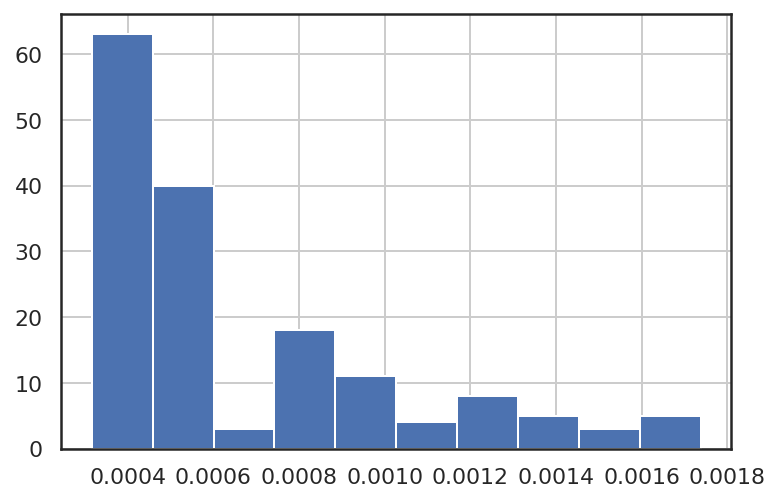

In [112]:
#Checking that the dataset is the same
corrected_het["chrX"].hist()

<AxesSubplot:>

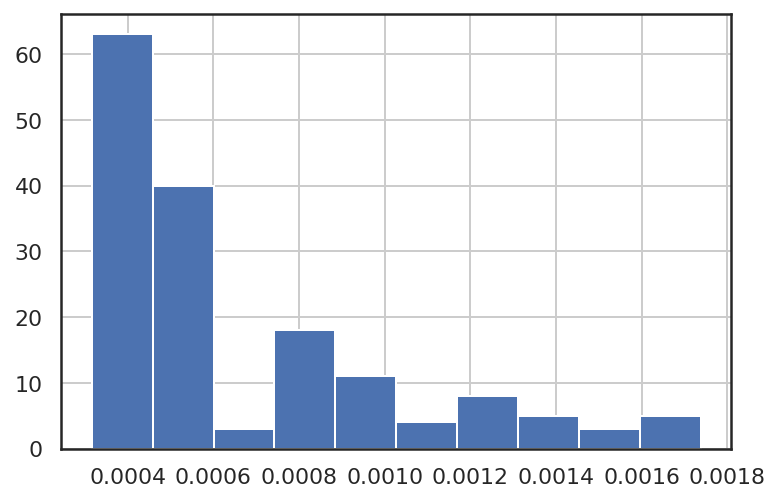

In [111]:
auto_x["chrX"].hist()

<AxesSubplot:>

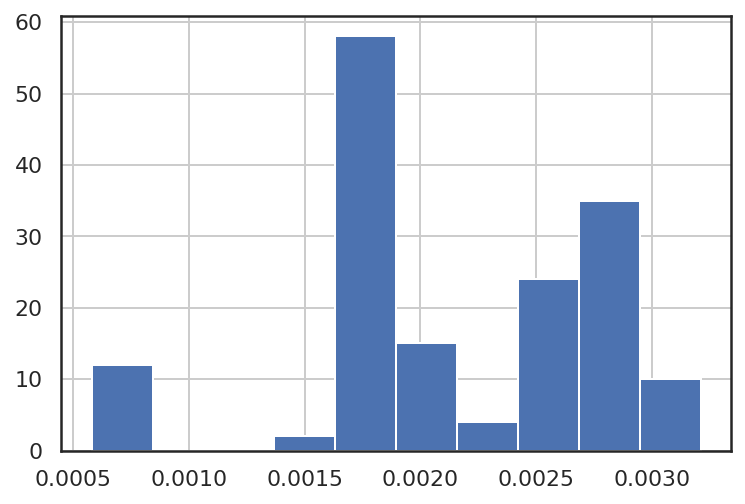

In [128]:
auto_x["autosomes"].hist()

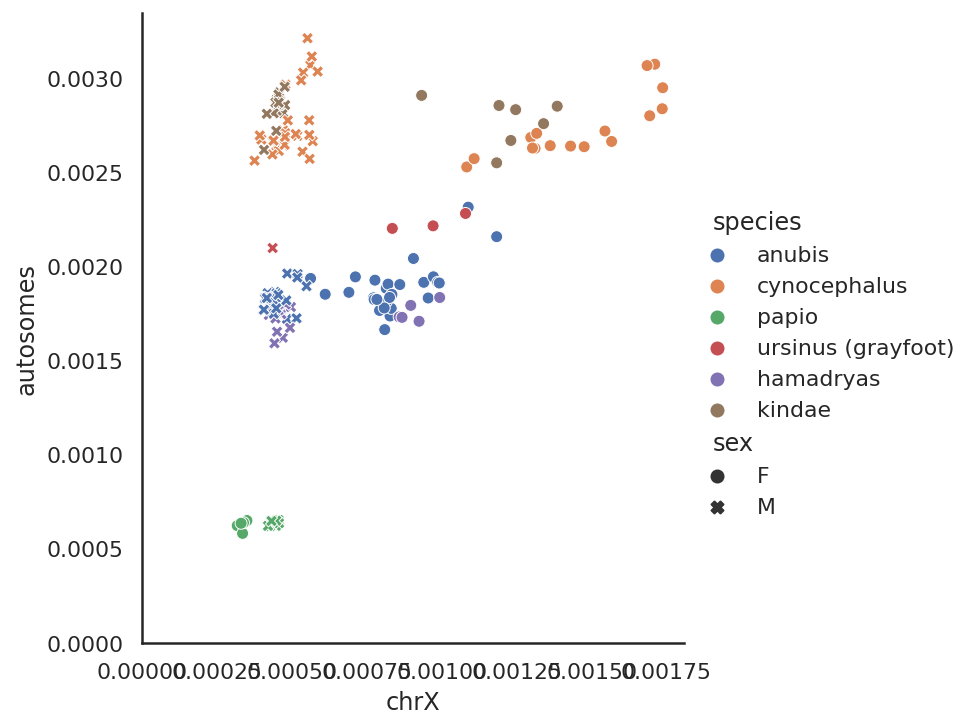

In [158]:
#Beginning the seaborn plotting
g = sns.relplot(data=auto_x, x="chrX", y="autosomes", hue="species", style="sex")
for ax in g.axes.flat:
    ax.set_xlim(xmin = 0)
    ax.set_ylim(ymin = 0)

In [144]:
#Subsetting to only look at females
auto_x_f = auto_x[auto_x["sex"] == "F"]
#And males, for good measure
auto_x_m = auto_x[auto_x["sex"] == "M"]
auto_x_f

,autosomes,chrX,sex,species,callability_x
0,0.001882,0.000814,F,anubis,138822791
1,0.001926,0.000777,F,anubis,138765170
3,0.001935,0.000562,F,anubis,124061544
4,0.001914,0.000940,F,anubis,138738283
6,0.002041,0.000905,F,anubis,138403000
...,...,...,...,...,...
154,0.002907,0.000933,F,kindae,138610826
155,0.002549,0.001183,F,kindae,138563679
156,0.002854,0.001191,F,kindae,138600825
157,0.002832,0.001247,F,kindae,138304741


In [145]:
#Checking up on mean heterozygosity
print(auto_x_f["autosomes"].mean())
print(auto_x_f["chrX"].mean())
print(auto_x_m["autosomes"].mean())
print(auto_x_m["chrX"].mean())
#Males have half of the heterozygosity of females, and the heterozygosity on the X is half of that on the autosomes.
#We should expect heterozygosity to be 3/4 on the X, which this is not close to.
#As males have heterozygosity

0.0021011986253636657
0.0010027207112197412
0.0021908158384305316
0.0004637983645358748


138274064.765625
122939162.95833333


<AxesSubplot:>

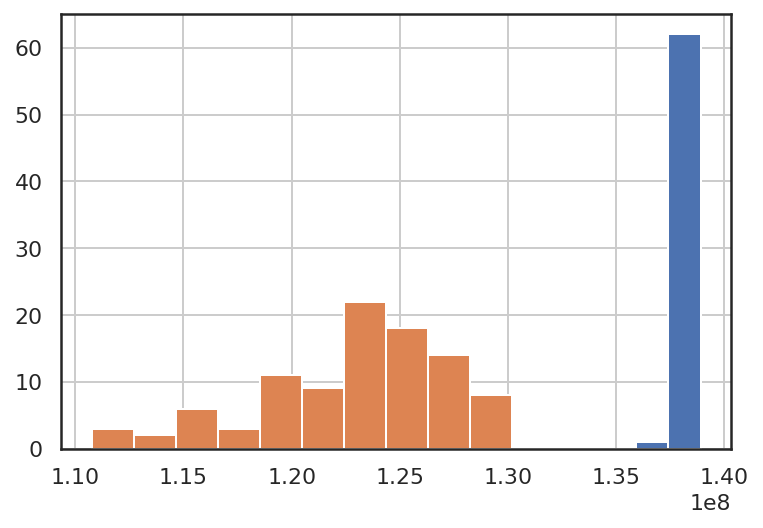

In [150]:
#Is there a difference in callability on the X?
print(auto_x_f["callability_x"].mean())
print(auto_x_m["callability_x"].mean())
#Not a large difference (but is significant), x has a length of 152835861
auto_x_f["callability_x"].hist()
auto_x_m["callability_x"].hist()

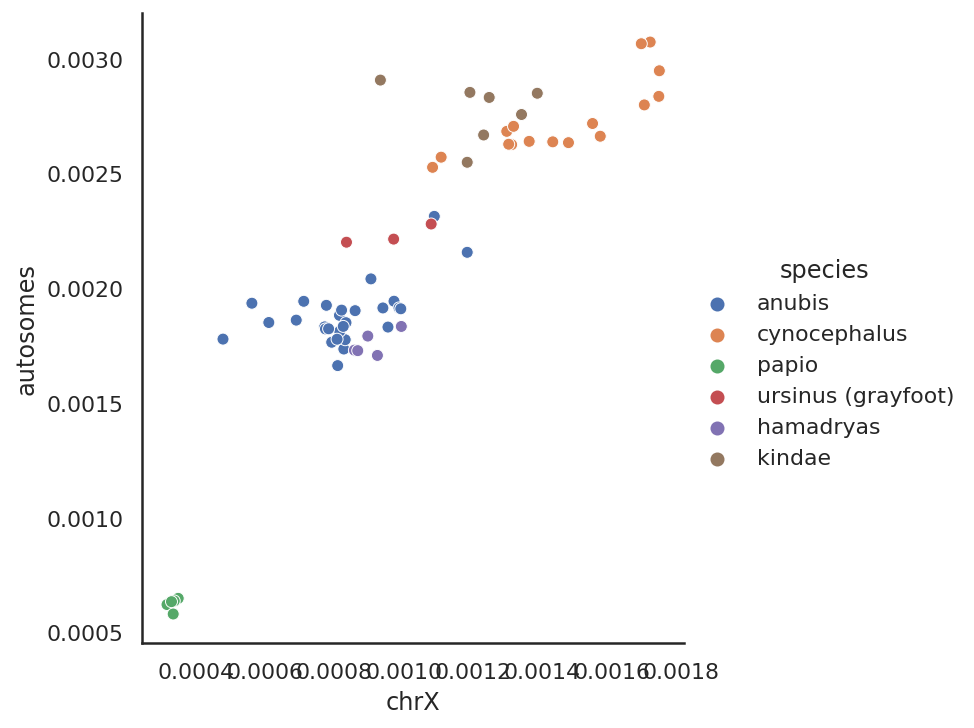

In [137]:
sns.relplot(data=auto_x_f, x="chrX", y="autosomes", hue="species")